# Import

In [1]:
import torch
import torchvision

# Models

In [2]:
from glcic.networks.completion_network import CompletionNetwork
from glcic.networks.discriminators import Discriminator

In [9]:
# import the completion network
cn = CompletionNetwork()
cn.load("../logs/models/cn_scrapped_weights")

# import the discriminator
discriminator = Discriminator()
from glcic.utils import get_latest_file_from_dir
checkpoint = torch.load(get_latest_file_from_dir("../logs/phase2_checkpoints/"))
discriminator.load_state_dict(checkpoint['model'])

Load: load_state dict from ../logs/models/cn_scrapped_weights


<All keys matched successfully>

# Dataset

In [14]:
# # choose a random test dir
# import os
# import random
# random_dir = random.choice(os.listdir('../data/val/'))

In [11]:
# load the dataset
test_dataset_dir = '../data/train/'
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_dir, transform=torchvision.transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# first batch
batch = next(iter(test_dataloader))[0]

# Test

In [12]:
# mask
from glcic.utils import *

lm,em = generate_mask(4)
replacement_val = torch.tensor([0.5062325495504219, 0.4255871700324652, 0.38299278586700136])
masked_batch = apply_mask(batch,em,replacement_val)

In [13]:
# complete
cn.eval()
_em = em[:,None,:,:]
with torch.no_grad():
    completed = cn(torch.cat((masked_batch,_em),dim=1))
completed = torch.where(_em,completed,masked_batch)
postprocessed = postprocess(completed, em,lm)

In [14]:
# discriminate
discriminator.eval()
with torch.no_grad():
    real_preds = discriminator(batch, lm)
    fake_pred = discriminator(postprocessed, lm)
real,fake = float(real_preds[0]),float(fake_pred[0])

# Display

Text(0.5, 1.0, 'Post-processed\nprediction is 63.7% real')

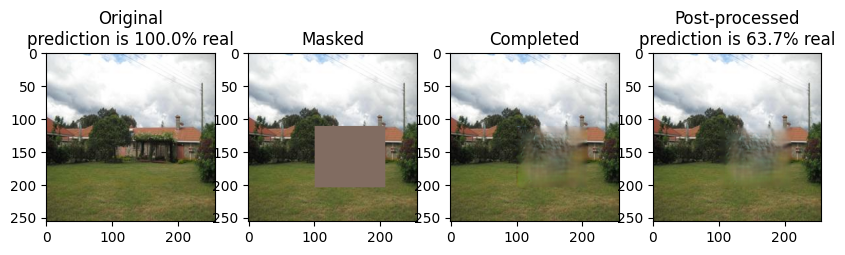

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(10, 15))

# display the original image
axes[0].imshow(batch[0].permute(1,2,0))
axes[0].set_title(f'Original\nprediction is {round(100*real,1)}% real')

# display the masked image
axes[1].imshow(masked_batch[0].permute(1,2,0))
axes[1].set_title('Masked')

# completed
axes[2].imshow(completed[0].permute(1,2,0))
axes[2].set_title('Completed')

# post-processed
axes[3].imshow(postprocessed[0].permute(1,2,0))
axes[3].set_title(f'Post-processed\nprediction is {round(100*fake,1)}% real')